Filter down to the patient level to be sure we are grouping by patient

20% fit coxPH

next 20%, find residual errors, do OLS

Test on remaining 60%.  

prior:  There is no structure in the data or in the errors


In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pathlib import Path
from lifelines.utils import concordance_index, survival_table_from_events, k_fold_cross_validation
from lifelines import CoxPHFitter, AalenAdditiveFitter
from sklearn.preprocessing import MinMaxScaler

Populating the interactive namespace from numpy and matplotlib


In [2]:
LIVER_PATH = Path('/DATA/BIO/GDC/liver')
LIVER_SAMPLES = LIVER_PATH/"samples"
EXP_PATH = LIVER_PATH/"exp_cox"


for d in [EXP_PATH]:
    if not d.exists():
        d.mkdir()

In [26]:
slides = pd.read_csv(LIVER_PATH/'slides.csv')
slides = slides.loc[slides.sample_type_id.isin([1])]
slide_level = 'level_1'
slides['days_proxy'] = slides.days_to_death.fillna(slides.days_to_last_follow_up)
slides = slides.loc[slides.days_proxy.notnull()]
slides['death'] = True
slides.loc[slides.days_to_last_follow_up.notnull(),'death'] = False    
slides['death'] = slides['death'].astype(int)

slides['sec_loc'] = (slides.section_location == 'TOP').astype(int)

features =  [    
    #'percent_tumor_nuclei',
    #'percent_tumor_cells',
    #'percent_normal_cells',
    'age_at_diagnosis',
    #'creation_datetime',
    #'sec_loc'
]

targets = [
    'days_proxy',
    'death',  
]
scaler = MinMaxScaler()
#fit_df = slides.loc[slides.sample_type_id == 1, features+targets].dropna()


patients = list(set(slides.submitter_id))
num_patients = len(patients)
split = 0.2
train_split_count = int(split * num_patients)

random_patients = np.random.permutation(patients)
train_patients = random_patients[                  0:  train_split_count]
valid_patients = random_patients[  train_split_count:2*train_split_count]
test_patients  = random_patients[2*train_split_count:]
print(num_patients)
print(len(train_patients))
print(len(valid_patients))
print(len(test_patients))

fit_df = slides[slides.submitter_id.isin(train_patients)].loc[slides.sample_type_id == 1, features+targets].dropna()
fit_df.loc[:,features] = scaler.fit_transform(fit_df[features])

valid_df = slides[slides.submitter_id.isin(valid_patients)].loc[slides.sample_type_id == 1, features+targets].dropna()
valid_df.loc[:,features] = scaler.fit_transform(valid_df[features])

test_df = slides[slides.submitter_id.isin(test_patients)].loc[slides.sample_type_id == 1, features+targets].dropna()
test_df.loc[:,features] = scaler.fit_transform(test_df[features])


376
75
75
226


In [27]:
surv_table = survival_table_from_events(fit_df['days_proxy'], fit_df['death'])
print(surv_table.head())


          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0        81       81
6.0             2         0         2         0       81
9.0             1         0         1         0       79
10.0            1         0         1         0       78
14.0            2         2         0         0       77


In [28]:
fit_df.shape

(81, 3)

### 1. Fix CoxPH curve to the data in the train set

In [29]:
model = CoxPHFitter()
k_fold_cross_validation(model,fit_df,'days_proxy', event_col='death')
#model.fit(fit_df, 'days_proxy', event_col='death')

[0.42, 0.6857142857142857, 0.4594594594594595, 0.46808510638297873, 0.5]

In [30]:
model.print_summary()

n=65, number of events=20

                   coef  exp(coef)  se(coef)      z      p  lower 0.95  upper 0.95   
age_at_diagnosis 0.2013     1.2230    1.0727 0.1877 0.8511     -1.9011      2.3037   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.551


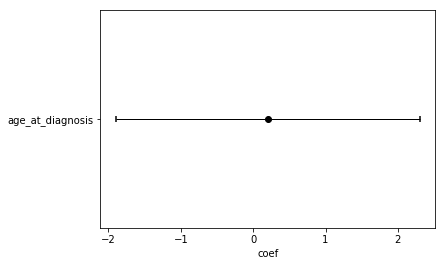

In [31]:
model.plot()

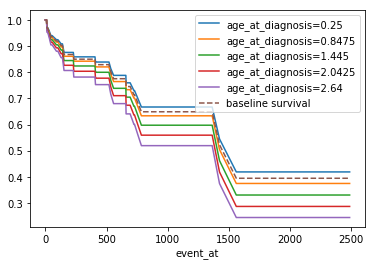

In [33]:
model.plot_covariate_groups('age_at_diagnosis' ,np.linspace(0.25,2.64,5))

What are the predictions when you account for the age factor? What are the residual errors?

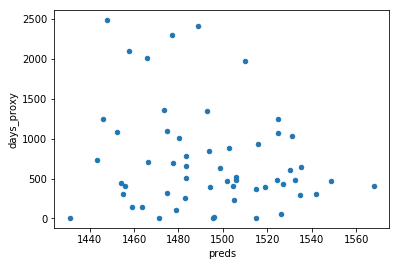

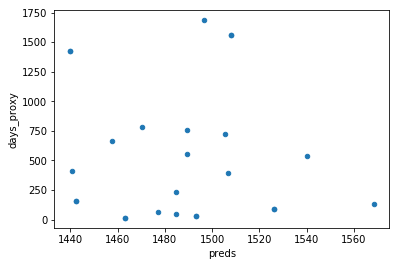

In [34]:
X = fit_df.drop(['days_proxy','death'],axis=1)
fit_df['preds'] = model.predict_expectation(X)

fit_df.loc[fit_df.death == 0,['preds','days_proxy','death']].plot(kind='scatter',x='preds',y='days_proxy')
fit_df.loc[fit_df.death != 0,['preds','days_proxy','death']].plot(kind='scatter',x='preds',y='days_proxy')

In [35]:
concordance_index(fit_df.days_proxy, fit_df.preds, fit_df.death)

0.5350488021295474

### 2. Check the error of the CoxPH model in validation data, correct for this error

In [67]:
valid_df['preds'] = model.predict_expectation( valid_df.drop(['days_proxy','death'],axis=1) )

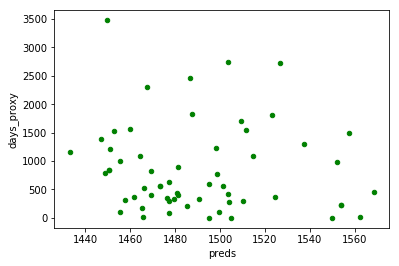

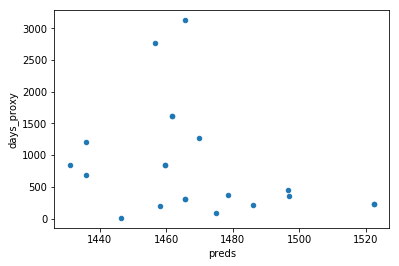

In [68]:
valid_df.loc[valid_df.death == 0,['preds','days_proxy','death']].plot(kind='scatter',x='preds',y='days_proxy',color='g')
valid_df.loc[valid_df.death != 0,['preds','days_proxy','death']].plot(kind='scatter',x='preds',y='days_proxy')

In [69]:
valid_df.head(10)

,age_at_diagnosis,days_proxy,death,preds,resid
7,0.860348,849.0,0,1450.742615,-601.742615
8,0.860348,849.0,0,1450.742615,-601.742615
16,0.312954,2728.0,0,1526.548764,1201.451236
22,0.398649,1085.0,0,1514.865434,-429.865434
30,0.613502,217.0,0,1485.265502,-1268.265502
38,0.498194,566.0,0,1501.205026,-935.205026
42,0.479968,425.0,0,1503.713257,-1078.713257
46,0.518630,1231.0,0,1498.389060,-267.389060
47,0.108850,219.0,0,1554.081681,-1335.081681
48,0.108850,219.0,0,1554.081681,-1335.081681


In [70]:
valid_df['resid'] = valid_df.days_proxy - valid_df.preds

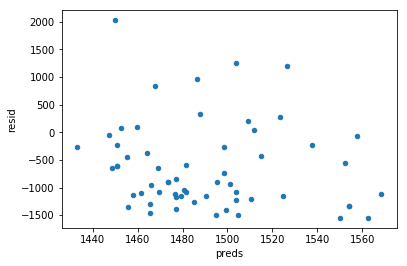

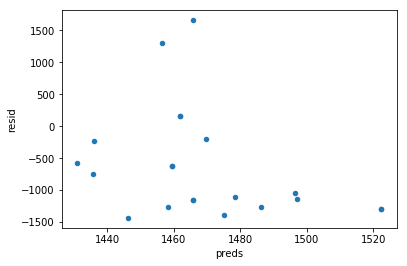

In [71]:
valid_df.loc[valid_df.death == 0,['resid','preds','death']].plot(kind='scatter',x='preds',y='resid')
valid_df.loc[valid_df.death != 0,['resid','preds','death']].plot(kind='scatter',x='preds',y='resid')

Will CIndex get better if we do a regression on the errors?  Then remove the obvious linear trend and scale properly?  or will CIndex all stay the same?


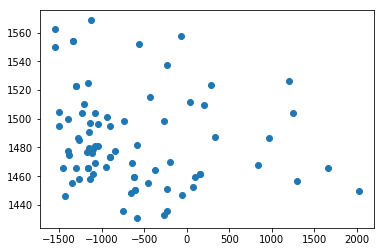

In [72]:
plt.scatter(valid_df.resid,valid_df.preds)

In [74]:
import statsmodels.formula.api as sm

ols_model = sm.ols(formula='resid ~ preds',data=valid_df).fit()
ols_pred_from_res = ols_model.predict(valid_df.preds)
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  resid   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.440
Date:                Thu, 21 Jun 2018   Prob (F-statistic):              0.122
Time:                        14:08:42   Log-Likelihood:                -646.20
No. Observations:                  80   AIC:                             1296.
Df Residuals:                      78   BIC:                             1301.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5643.2801   4020.775      1.404      0.164   -2361.468    1.36e+04
preds         -4.2290      2.707     -1.562      0.122      -9.619       1.161
==============================================================================
Omnibus:                       23.427   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.403
Skew:                           1.377   Prob(JB):                     1.52e-07
Kurtosis:                       4.356   Cond. No.                     6.77e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

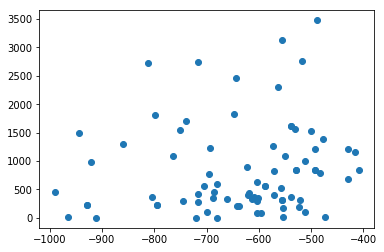

In [75]:
plt.scatter(ols_pred_from_res,valid_df.days_proxy)

In [76]:
concordance_index(valid_df.days_proxy, ols_pred_from_res, valid_df.death)

0.44678362573099417